In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import fsolve, leastsq
import scipy.constants as ct
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Define constants
ISAT = 1e-9 # Saturation current
N = 1.7
T1 = 350
Q = ct.physical_constants['atomic unit of charge'][0]
KB = ct.physical_constants['Boltzmann constant'][0]
inital_voltages = np.arange(0.1, 2.5, 0.1)
R1 = 1.1e4

In [3]:
step_size = (2.5 - 0.1) / 0.1
V = [1 for i in range(int(step_size + 1))]

In [4]:
def current(Vd, Is, n, T):
    return Is * (np.exp((Vd * Q) / (n * KB * T)) - 1)

def error_func(Vd, Vs, Is, n, R, T):
    return (Vd / R) - (Vs / R) + current(Vd, Is, n, T)

In [5]:
diode_voltage = fsolve(
                error_func,
                V,
                args=(inital_voltages, ISAT, N, R1, T1)
            )
diode_current = current(diode_voltage, ISAT, N, T1)

In [6]:
diode_voltage

array([0.09993376, 0.19947277, 0.29644374, 0.3813319 , 0.4406315 ,
       0.4776876 , 0.50230459, 0.52012676, 0.53389711, 0.54503839,
       0.55435716, 0.56234689, 0.56932861, 0.57552165, 0.58108195,
       0.58612404, 0.59073435, 0.59497963, 0.59891245, 0.60257491,
       0.6060012 , 0.60921952, 0.61225331, 0.61512231])

In [7]:
diode_current

array([6.02199411e-09, 4.79302369e-08, 3.23296545e-07, 1.69710024e-06,
       5.39713543e-06, 1.11193093e-05, 1.79723102e-05, 2.54430214e-05,
       3.32820811e-05, 4.13601465e-05, 4.96038950e-05, 5.79684647e-05,
       6.64246721e-05, 7.49525773e-05, 8.35380046e-05, 9.21705422e-05,
       1.00842332e-04, 1.09547306e-04, 1.18280686e-04, 1.27038645e-04,
       1.35818072e-04, 1.44616407e-04, 1.53431519e-04, 1.62261609e-04])

In [8]:
plot_diode_current = np.log(diode_current)
plot_diode_current

array([-18.92784739, -16.85351928, -14.94469584, -13.28658951,
       -12.12964222, -11.40682739, -10.9266783 , -10.57906906,
       -10.31049141, -10.09319278,  -9.9114412 ,  -9.75561141,
        -9.619442  ,  -9.49865495,  -9.39020888,  -9.29186998,
        -9.20195233,  -9.11915408,  -9.04245006,  -8.97101923,
        -8.90419427,  -8.84142579,  -8.78225622,  -8.72630066])

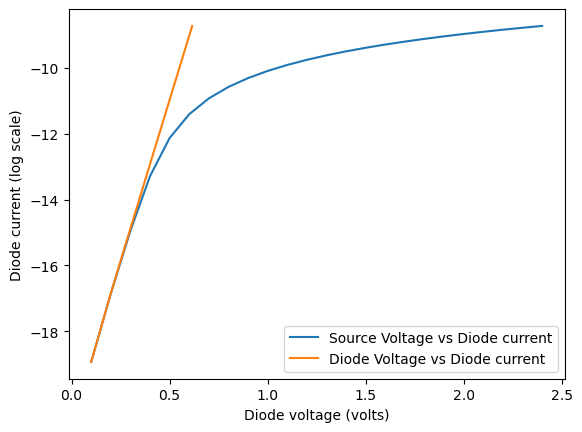

In [9]:
plt.plot(inital_voltages, plot_diode_current, label="Source Voltage vs Diode current")
plt.plot(diode_voltage, plot_diode_current, label="Diode Voltage vs Diode current")
plt.ylabel("Diode current (log scale)")
plt.xlabel("Diode voltage (volts)")
plt.legend()
plt.show()

In [10]:
# Read the contents of diode.txt file
data = pd.read_csv('DiodeIV.txt', header=None, sep=' ')
source_voltages = []
measured_current = []
for V_s, I_d in data.values:
    source_voltages.append(V_s)
    measured_current.append(I_d)
    
source_voltages = np.asarray(source_voltages)
measured_current = np.asarray(measured_current)

In [11]:
AREA = 1e-8
TEMP2 = 375
R2 = 1e4
PHI = 0.8
IDEALITY = 1.5

# Functions
def compute_diode_current(Is, Vs, R, n, I):
    Vt = IDEALITY * KB * TEMP2 / Q
    result = Is * (np.exp(((Vs - I * R) * Q) / (n * KB * TEMP2)) - 1)
    return result

def Isat(phi):
    return AREA * TEMP2**2 * np.exp(-phi * Q / (KB * TEMP2))

# Define the residual functions
def residual_phi(phi, n, R):
    Is_temp = Isat(phi)
    return np.absolute(measured_current - compute_diode_current(Is_temp, source_voltages, R, n, measured_current))

def residual_n(n, phi, R):
    Is_temp = Isat(phi)
    return np.absolute(measured_current - compute_diode_current(Is_temp, source_voltages, R, n, measured_current))

def residual_R(R, n, phi):
    Is_temp = Isat(phi)
    return np.absolute(measured_current - compute_diode_current(Is_temp, source_voltages, R, n, measured_current))

In [12]:
# Set the thresholds
THRESHOLD = 1e-6
avg_val = 10
MAX_ITER = 1e6
iter_count = 0

# Initialization
R = [R2]  # Initial guess for resistor R
phi = [PHI]  # Initial guess for phi
n = [IDEALITY]  # Initial guess for ideality factor n

res_avg = THRESHOLD + 1  # Initialize res_avg to a value greater than RES_ERR_THRESH
count = 1  # Initialize iteration count

# Iterative optimization loop
while res_avg > THRESHOLD and count < MAX_ITER:
    # Perform the least squares optimization to get the values of R, phi, and n
    R = leastsq(residual_R, R[0], args=(n[0], phi[0]))[0]
    phi = leastsq(residual_phi, phi[0], args=(n[0], R))[0]
    n = leastsq(residual_n, n[0], args=(phi[0], R))[0]

    # Calculate the average residual error
    res_avg = np.average(np.absolute(residual_phi(phi[0], n[0], R)))

    # Print iteration progress
    if count % 100 == 0:
        print(f"Iter#: {count} ; phi: {phi[0]:.4f} ; n: {n[0]:.4f} ; R: {R[0]:.2f} ; Residual: {res_avg:.3e}")

    # Increment the iteration count
    count += 1

Iter#: 100 ; phi: 0.6419 ; n: 1.4985 ; R: 1143.32 ; Residual: 3.917e-05
Iter#: 200 ; phi: 0.6422 ; n: 1.4978 ; R: 1143.33 ; Residual: 3.913e-05
Iter#: 300 ; phi: 0.6425 ; n: 1.4971 ; R: 1143.34 ; Residual: 3.908e-05
Iter#: 400 ; phi: 0.6428 ; n: 1.4963 ; R: 1143.35 ; Residual: 3.902e-05
Iter#: 500 ; phi: 0.6431 ; n: 1.4956 ; R: 1143.36 ; Residual: 3.897e-05
Iter#: 600 ; phi: 0.6434 ; n: 1.4949 ; R: 1143.37 ; Residual: 3.892e-05
Iter#: 700 ; phi: 0.6437 ; n: 1.4942 ; R: 1143.39 ; Residual: 3.887e-05
Iter#: 800 ; phi: 0.6440 ; n: 1.4935 ; R: 1143.40 ; Residual: 3.882e-05
Iter#: 900 ; phi: 0.6443 ; n: 1.4927 ; R: 1143.41 ; Residual: 3.876e-05
Iter#: 1000 ; phi: 0.6446 ; n: 1.4920 ; R: 1143.42 ; Residual: 3.871e-05
Iter#: 1100 ; phi: 0.6449 ; n: 1.4913 ; R: 1143.43 ; Residual: 3.866e-05
Iter#: 1200 ; phi: 0.6452 ; n: 1.4906 ; R: 1143.44 ; Residual: 3.861e-05
Iter#: 1300 ; phi: 0.6455 ; n: 1.4899 ; R: 1143.45 ; Residual: 3.856e-05
Iter#: 1400 ; phi: 0.6458 ; n: 1.4892 ; R: 1143.47 ; Residua

Iter#: 11400 ; phi: 0.6733 ; n: 1.4262 ; R: 1144.46 ; Residual: 3.381e-05
Iter#: 11500 ; phi: 0.6735 ; n: 1.4256 ; R: 1144.47 ; Residual: 3.377e-05
Iter#: 11600 ; phi: 0.6738 ; n: 1.4251 ; R: 1144.48 ; Residual: 3.373e-05
Iter#: 11700 ; phi: 0.6741 ; n: 1.4245 ; R: 1144.49 ; Residual: 3.368e-05
Iter#: 11800 ; phi: 0.6743 ; n: 1.4240 ; R: 1144.50 ; Residual: 3.364e-05
Iter#: 11900 ; phi: 0.6746 ; n: 1.4234 ; R: 1144.51 ; Residual: 3.360e-05
Iter#: 12000 ; phi: 0.6748 ; n: 1.4229 ; R: 1144.51 ; Residual: 3.355e-05
Iter#: 12100 ; phi: 0.6751 ; n: 1.4223 ; R: 1144.52 ; Residual: 3.351e-05
Iter#: 12200 ; phi: 0.6753 ; n: 1.4218 ; R: 1144.53 ; Residual: 3.347e-05
Iter#: 12300 ; phi: 0.6756 ; n: 1.4212 ; R: 1144.54 ; Residual: 3.343e-05
Iter#: 12400 ; phi: 0.6758 ; n: 1.4207 ; R: 1144.55 ; Residual: 3.338e-05
Iter#: 12500 ; phi: 0.6761 ; n: 1.4201 ; R: 1144.56 ; Residual: 3.334e-05
Iter#: 12600 ; phi: 0.6763 ; n: 1.4196 ; R: 1144.57 ; Residual: 3.330e-05
Iter#: 12700 ; phi: 0.6766 ; n: 1.4190

Iter#: 22500 ; phi: 0.6995 ; n: 1.3709 ; R: 1145.33 ; Residual: 2.944e-05
Iter#: 22600 ; phi: 0.6997 ; n: 1.3705 ; R: 1145.34 ; Residual: 2.940e-05
Iter#: 22700 ; phi: 0.7000 ; n: 1.3700 ; R: 1145.35 ; Residual: 2.937e-05
Iter#: 22800 ; phi: 0.7002 ; n: 1.3696 ; R: 1145.35 ; Residual: 2.933e-05
Iter#: 22900 ; phi: 0.7004 ; n: 1.3691 ; R: 1145.36 ; Residual: 2.929e-05
Iter#: 23000 ; phi: 0.7006 ; n: 1.3687 ; R: 1145.37 ; Residual: 2.926e-05
Iter#: 23100 ; phi: 0.7008 ; n: 1.3683 ; R: 1145.37 ; Residual: 2.922e-05
Iter#: 23200 ; phi: 0.7010 ; n: 1.3678 ; R: 1145.38 ; Residual: 2.919e-05
Iter#: 23300 ; phi: 0.7013 ; n: 1.3674 ; R: 1145.39 ; Residual: 2.915e-05
Iter#: 23400 ; phi: 0.7015 ; n: 1.3670 ; R: 1145.40 ; Residual: 2.912e-05
Iter#: 23500 ; phi: 0.7017 ; n: 1.3665 ; R: 1145.40 ; Residual: 2.908e-05
Iter#: 23600 ; phi: 0.7019 ; n: 1.3661 ; R: 1145.41 ; Residual: 2.904e-05
Iter#: 23700 ; phi: 0.7021 ; n: 1.3657 ; R: 1145.42 ; Residual: 2.901e-05
Iter#: 23800 ; phi: 0.7023 ; n: 1.3652

Iter#: 33800 ; phi: 0.7224 ; n: 1.3260 ; R: 1146.04 ; Residual: 2.569e-05
Iter#: 33900 ; phi: 0.7226 ; n: 1.3257 ; R: 1146.04 ; Residual: 2.566e-05
Iter#: 34000 ; phi: 0.7228 ; n: 1.3253 ; R: 1146.05 ; Residual: 2.563e-05
Iter#: 34100 ; phi: 0.7230 ; n: 1.3250 ; R: 1146.05 ; Residual: 2.560e-05
Iter#: 34200 ; phi: 0.7232 ; n: 1.3246 ; R: 1146.06 ; Residual: 2.557e-05
Iter#: 34300 ; phi: 0.7234 ; n: 1.3242 ; R: 1146.07 ; Residual: 2.553e-05
Iter#: 34400 ; phi: 0.7236 ; n: 1.3239 ; R: 1146.07 ; Residual: 2.550e-05
Iter#: 34500 ; phi: 0.7237 ; n: 1.3235 ; R: 1146.08 ; Residual: 2.547e-05
Iter#: 34600 ; phi: 0.7239 ; n: 1.3232 ; R: 1146.08 ; Residual: 2.544e-05
Iter#: 34700 ; phi: 0.7241 ; n: 1.3228 ; R: 1146.09 ; Residual: 2.541e-05
Iter#: 34800 ; phi: 0.7243 ; n: 1.3225 ; R: 1146.09 ; Residual: 2.538e-05
Iter#: 34900 ; phi: 0.7245 ; n: 1.3221 ; R: 1146.10 ; Residual: 2.535e-05
Iter#: 35000 ; phi: 0.7247 ; n: 1.3218 ; R: 1146.10 ; Residual: 2.532e-05
Iter#: 35100 ; phi: 0.7249 ; n: 1.3214

Iter#: 45000 ; phi: 0.7420 ; n: 1.2899 ; R: 1146.60 ; Residual: 2.253e-05
Iter#: 45100 ; phi: 0.7422 ; n: 1.2896 ; R: 1146.61 ; Residual: 2.250e-05
Iter#: 45200 ; phi: 0.7424 ; n: 1.2893 ; R: 1146.61 ; Residual: 2.247e-05
Iter#: 45300 ; phi: 0.7425 ; n: 1.2890 ; R: 1146.62 ; Residual: 2.245e-05
Iter#: 45400 ; phi: 0.7427 ; n: 1.2887 ; R: 1146.62 ; Residual: 2.242e-05
Iter#: 45500 ; phi: 0.7428 ; n: 1.2884 ; R: 1146.63 ; Residual: 2.240e-05
Iter#: 45600 ; phi: 0.7430 ; n: 1.2881 ; R: 1146.63 ; Residual: 2.237e-05
Iter#: 45700 ; phi: 0.7432 ; n: 1.2879 ; R: 1146.63 ; Residual: 2.234e-05
Iter#: 45800 ; phi: 0.7433 ; n: 1.2876 ; R: 1146.64 ; Residual: 2.232e-05
Iter#: 45900 ; phi: 0.7435 ; n: 1.2873 ; R: 1146.64 ; Residual: 2.229e-05
Iter#: 46000 ; phi: 0.7436 ; n: 1.2870 ; R: 1146.65 ; Residual: 2.227e-05
Iter#: 46100 ; phi: 0.7438 ; n: 1.2867 ; R: 1146.65 ; Residual: 2.224e-05
Iter#: 46200 ; phi: 0.7440 ; n: 1.2864 ; R: 1146.66 ; Residual: 2.222e-05
Iter#: 46300 ; phi: 0.7441 ; n: 1.2861

Iter#: 56100 ; phi: 0.7589 ; n: 1.2603 ; R: 1147.06 ; Residual: 1.984e-05
Iter#: 56200 ; phi: 0.7591 ; n: 1.2601 ; R: 1147.07 ; Residual: 1.982e-05
Iter#: 56300 ; phi: 0.7592 ; n: 1.2598 ; R: 1147.07 ; Residual: 1.979e-05
Iter#: 56400 ; phi: 0.7593 ; n: 1.2596 ; R: 1147.08 ; Residual: 1.977e-05
Iter#: 56500 ; phi: 0.7595 ; n: 1.2594 ; R: 1147.08 ; Residual: 1.975e-05
Iter#: 56600 ; phi: 0.7596 ; n: 1.2591 ; R: 1147.08 ; Residual: 1.973e-05
Iter#: 56700 ; phi: 0.7598 ; n: 1.2589 ; R: 1147.09 ; Residual: 1.970e-05
Iter#: 56800 ; phi: 0.7599 ; n: 1.2586 ; R: 1147.09 ; Residual: 1.968e-05
Iter#: 56900 ; phi: 0.7600 ; n: 1.2584 ; R: 1147.09 ; Residual: 1.966e-05
Iter#: 57000 ; phi: 0.7602 ; n: 1.2582 ; R: 1147.10 ; Residual: 1.964e-05
Iter#: 57100 ; phi: 0.7603 ; n: 1.2579 ; R: 1147.10 ; Residual: 1.962e-05
Iter#: 57200 ; phi: 0.7605 ; n: 1.2577 ; R: 1147.11 ; Residual: 1.959e-05
Iter#: 57300 ; phi: 0.7606 ; n: 1.2574 ; R: 1147.11 ; Residual: 1.957e-05
Iter#: 57400 ; phi: 0.7607 ; n: 1.2572

Iter#: 67200 ; phi: 0.7737 ; n: 1.2356 ; R: 1147.45 ; Residual: 1.752e-05
Iter#: 67300 ; phi: 0.7738 ; n: 1.2354 ; R: 1147.45 ; Residual: 1.750e-05
Iter#: 67400 ; phi: 0.7739 ; n: 1.2352 ; R: 1147.46 ; Residual: 1.748e-05
Iter#: 67500 ; phi: 0.7740 ; n: 1.2350 ; R: 1147.46 ; Residual: 1.746e-05
Iter#: 67600 ; phi: 0.7742 ; n: 1.2348 ; R: 1147.46 ; Residual: 1.744e-05
Iter#: 67700 ; phi: 0.7743 ; n: 1.2346 ; R: 1147.47 ; Residual: 1.742e-05
Iter#: 67800 ; phi: 0.7744 ; n: 1.2344 ; R: 1147.47 ; Residual: 1.740e-05
Iter#: 67900 ; phi: 0.7745 ; n: 1.2342 ; R: 1147.47 ; Residual: 1.738e-05
Iter#: 68000 ; phi: 0.7746 ; n: 1.2340 ; R: 1147.47 ; Residual: 1.736e-05
Iter#: 68100 ; phi: 0.7748 ; n: 1.2338 ; R: 1147.48 ; Residual: 1.734e-05
Iter#: 68200 ; phi: 0.7749 ; n: 1.2336 ; R: 1147.48 ; Residual: 1.732e-05
Iter#: 68300 ; phi: 0.7750 ; n: 1.2334 ; R: 1147.48 ; Residual: 1.731e-05
Iter#: 68400 ; phi: 0.7751 ; n: 1.2332 ; R: 1147.49 ; Residual: 1.729e-05
Iter#: 68500 ; phi: 0.7753 ; n: 1.2330

Iter#: 78300 ; phi: 0.7866 ; n: 1.2147 ; R: 1147.77 ; Residual: 1.550e-05
Iter#: 78400 ; phi: 0.7867 ; n: 1.2145 ; R: 1147.78 ; Residual: 1.549e-05
Iter#: 78500 ; phi: 0.7868 ; n: 1.2143 ; R: 1147.78 ; Residual: 1.547e-05
Iter#: 78600 ; phi: 0.7869 ; n: 1.2142 ; R: 1147.78 ; Residual: 1.545e-05
Iter#: 78700 ; phi: 0.7870 ; n: 1.2140 ; R: 1147.78 ; Residual: 1.544e-05
Iter#: 78800 ; phi: 0.7871 ; n: 1.2138 ; R: 1147.79 ; Residual: 1.542e-05
Iter#: 78900 ; phi: 0.7872 ; n: 1.2136 ; R: 1147.79 ; Residual: 1.540e-05
Iter#: 79000 ; phi: 0.7873 ; n: 1.2135 ; R: 1147.79 ; Residual: 1.538e-05
Iter#: 79100 ; phi: 0.7875 ; n: 1.2133 ; R: 1147.80 ; Residual: 1.537e-05
Iter#: 79200 ; phi: 0.7876 ; n: 1.2131 ; R: 1147.80 ; Residual: 1.535e-05
Iter#: 79300 ; phi: 0.7877 ; n: 1.2130 ; R: 1147.80 ; Residual: 1.533e-05
Iter#: 79400 ; phi: 0.7878 ; n: 1.2128 ; R: 1147.80 ; Residual: 1.532e-05
Iter#: 79500 ; phi: 0.7879 ; n: 1.2126 ; R: 1147.81 ; Residual: 1.530e-05
Iter#: 79600 ; phi: 0.7880 ; n: 1.2125

Iter#: 89500 ; phi: 0.7981 ; n: 1.1967 ; R: 1148.05 ; Residual: 1.373e-05
Iter#: 89600 ; phi: 0.7982 ; n: 1.1966 ; R: 1148.05 ; Residual: 1.372e-05
Iter#: 89700 ; phi: 0.7982 ; n: 1.1964 ; R: 1148.06 ; Residual: 1.370e-05
Iter#: 89800 ; phi: 0.7983 ; n: 1.1963 ; R: 1148.06 ; Residual: 1.369e-05
Iter#: 89900 ; phi: 0.7984 ; n: 1.1961 ; R: 1148.06 ; Residual: 1.367e-05
Iter#: 90000 ; phi: 0.7985 ; n: 1.1960 ; R: 1148.06 ; Residual: 1.366e-05
Iter#: 90100 ; phi: 0.7986 ; n: 1.1959 ; R: 1148.07 ; Residual: 1.364e-05
Iter#: 90200 ; phi: 0.7987 ; n: 1.1957 ; R: 1148.07 ; Residual: 1.363e-05
Iter#: 90300 ; phi: 0.7988 ; n: 1.1956 ; R: 1148.07 ; Residual: 1.361e-05
Iter#: 90400 ; phi: 0.7989 ; n: 1.1954 ; R: 1148.07 ; Residual: 1.360e-05
Iter#: 90500 ; phi: 0.7990 ; n: 1.1953 ; R: 1148.07 ; Residual: 1.358e-05
Iter#: 90600 ; phi: 0.7991 ; n: 1.1951 ; R: 1148.08 ; Residual: 1.357e-05
Iter#: 90700 ; phi: 0.7992 ; n: 1.1950 ; R: 1148.08 ; Residual: 1.355e-05
Iter#: 90800 ; phi: 0.7993 ; n: 1.1948

Iter#: 100900 ; phi: 0.8083 ; n: 1.1811 ; R: 1148.29 ; Residual: 1.215e-05
Iter#: 101000 ; phi: 0.8084 ; n: 1.1810 ; R: 1148.30 ; Residual: 1.214e-05
Iter#: 101100 ; phi: 0.8085 ; n: 1.1809 ; R: 1148.30 ; Residual: 1.213e-05
Iter#: 101200 ; phi: 0.8086 ; n: 1.1807 ; R: 1148.30 ; Residual: 1.212e-05
Iter#: 101300 ; phi: 0.8087 ; n: 1.1806 ; R: 1148.30 ; Residual: 1.210e-05
Iter#: 101400 ; phi: 0.8087 ; n: 1.1805 ; R: 1148.30 ; Residual: 1.209e-05
Iter#: 101500 ; phi: 0.8088 ; n: 1.1803 ; R: 1148.31 ; Residual: 1.208e-05
Iter#: 101600 ; phi: 0.8089 ; n: 1.1802 ; R: 1148.31 ; Residual: 1.206e-05
Iter#: 101700 ; phi: 0.8090 ; n: 1.1801 ; R: 1148.31 ; Residual: 1.205e-05
Iter#: 101800 ; phi: 0.8091 ; n: 1.1800 ; R: 1148.31 ; Residual: 1.204e-05
Iter#: 101900 ; phi: 0.8092 ; n: 1.1798 ; R: 1148.31 ; Residual: 1.203e-05
Iter#: 102000 ; phi: 0.8092 ; n: 1.1797 ; R: 1148.32 ; Residual: 1.201e-05
Iter#: 102100 ; phi: 0.8093 ; n: 1.1796 ; R: 1148.32 ; Residual: 1.200e-05
Iter#: 102200 ; phi: 0.80

Iter#: 112100 ; phi: 0.8172 ; n: 1.1679 ; R: 1148.50 ; Residual: 1.080e-05
Iter#: 112200 ; phi: 0.8173 ; n: 1.1678 ; R: 1148.50 ; Residual: 1.079e-05
Iter#: 112300 ; phi: 0.8174 ; n: 1.1677 ; R: 1148.50 ; Residual: 1.078e-05
Iter#: 112400 ; phi: 0.8174 ; n: 1.1676 ; R: 1148.50 ; Residual: 1.076e-05
Iter#: 112500 ; phi: 0.8175 ; n: 1.1675 ; R: 1148.50 ; Residual: 1.075e-05
Iter#: 112600 ; phi: 0.8176 ; n: 1.1673 ; R: 1148.51 ; Residual: 1.074e-05
Iter#: 112700 ; phi: 0.8177 ; n: 1.1672 ; R: 1148.51 ; Residual: 1.073e-05
Iter#: 112800 ; phi: 0.8177 ; n: 1.1671 ; R: 1148.51 ; Residual: 1.072e-05
Iter#: 112900 ; phi: 0.8178 ; n: 1.1670 ; R: 1148.51 ; Residual: 1.071e-05
Iter#: 113000 ; phi: 0.8179 ; n: 1.1669 ; R: 1148.51 ; Residual: 1.070e-05
Iter#: 113100 ; phi: 0.8180 ; n: 1.1668 ; R: 1148.51 ; Residual: 1.069e-05
Iter#: 113200 ; phi: 0.8180 ; n: 1.1667 ; R: 1148.52 ; Residual: 1.067e-05
Iter#: 113300 ; phi: 0.8181 ; n: 1.1666 ; R: 1148.52 ; Residual: 1.066e-05
Iter#: 113400 ; phi: 0.81

Iter#: 123100 ; phi: 0.8250 ; n: 1.1566 ; R: 1148.67 ; Residual: 9.625e-06
Iter#: 123200 ; phi: 0.8250 ; n: 1.1565 ; R: 1148.67 ; Residual: 9.615e-06
Iter#: 123300 ; phi: 0.8251 ; n: 1.1564 ; R: 1148.67 ; Residual: 9.605e-06
Iter#: 123400 ; phi: 0.8252 ; n: 1.1564 ; R: 1148.68 ; Residual: 9.595e-06
Iter#: 123500 ; phi: 0.8252 ; n: 1.1563 ; R: 1148.68 ; Residual: 9.585e-06
Iter#: 123600 ; phi: 0.8253 ; n: 1.1562 ; R: 1148.68 ; Residual: 9.575e-06
Iter#: 123700 ; phi: 0.8254 ; n: 1.1561 ; R: 1148.68 ; Residual: 9.565e-06
Iter#: 123800 ; phi: 0.8254 ; n: 1.1560 ; R: 1148.68 ; Residual: 9.555e-06
Iter#: 123900 ; phi: 0.8255 ; n: 1.1559 ; R: 1148.68 ; Residual: 9.545e-06
Iter#: 124000 ; phi: 0.8256 ; n: 1.1558 ; R: 1148.68 ; Residual: 9.535e-06
Iter#: 124100 ; phi: 0.8256 ; n: 1.1557 ; R: 1148.69 ; Residual: 9.525e-06
Iter#: 124200 ; phi: 0.8257 ; n: 1.1556 ; R: 1148.69 ; Residual: 9.516e-06
Iter#: 124300 ; phi: 0.8257 ; n: 1.1555 ; R: 1148.69 ; Residual: 9.506e-06
Iter#: 124400 ; phi: 0.82

Iter#: 134400 ; phi: 0.8320 ; n: 1.1466 ; R: 1148.83 ; Residual: 8.562e-06
Iter#: 134500 ; phi: 0.8321 ; n: 1.1465 ; R: 1148.83 ; Residual: 8.553e-06
Iter#: 134600 ; phi: 0.8321 ; n: 1.1464 ; R: 1148.83 ; Residual: 8.544e-06
Iter#: 134700 ; phi: 0.8322 ; n: 1.1463 ; R: 1148.83 ; Residual: 8.535e-06
Iter#: 134800 ; phi: 0.8322 ; n: 1.1462 ; R: 1148.83 ; Residual: 8.527e-06
Iter#: 134900 ; phi: 0.8323 ; n: 1.1462 ; R: 1148.83 ; Residual: 8.518e-06
Iter#: 135000 ; phi: 0.8324 ; n: 1.1461 ; R: 1148.83 ; Residual: 8.509e-06
Iter#: 135100 ; phi: 0.8324 ; n: 1.1460 ; R: 1148.84 ; Residual: 8.500e-06
Iter#: 135200 ; phi: 0.8325 ; n: 1.1459 ; R: 1148.84 ; Residual: 8.491e-06
Iter#: 135300 ; phi: 0.8325 ; n: 1.1458 ; R: 1148.84 ; Residual: 8.483e-06
Iter#: 135400 ; phi: 0.8326 ; n: 1.1457 ; R: 1148.84 ; Residual: 8.474e-06
Iter#: 135500 ; phi: 0.8326 ; n: 1.1457 ; R: 1148.84 ; Residual: 8.465e-06
Iter#: 135600 ; phi: 0.8327 ; n: 1.1456 ; R: 1148.84 ; Residual: 8.457e-06
Iter#: 135700 ; phi: 0.83

Iter#: 145600 ; phi: 0.8382 ; n: 1.1379 ; R: 1148.96 ; Residual: 7.631e-06
Iter#: 145700 ; phi: 0.8383 ; n: 1.1378 ; R: 1148.96 ; Residual: 7.623e-06
Iter#: 145800 ; phi: 0.8383 ; n: 1.1377 ; R: 1148.96 ; Residual: 7.615e-06
Iter#: 145900 ; phi: 0.8384 ; n: 1.1377 ; R: 1148.96 ; Residual: 7.608e-06
Iter#: 146000 ; phi: 0.8384 ; n: 1.1376 ; R: 1148.96 ; Residual: 7.600e-06
Iter#: 146100 ; phi: 0.8385 ; n: 1.1375 ; R: 1148.97 ; Residual: 7.592e-06
Iter#: 146200 ; phi: 0.8385 ; n: 1.1374 ; R: 1148.97 ; Residual: 7.584e-06
Iter#: 146300 ; phi: 0.8386 ; n: 1.1374 ; R: 1148.97 ; Residual: 7.577e-06
Iter#: 146400 ; phi: 0.8386 ; n: 1.1373 ; R: 1148.97 ; Residual: 7.569e-06
Iter#: 146500 ; phi: 0.8387 ; n: 1.1372 ; R: 1148.97 ; Residual: 7.561e-06
Iter#: 146600 ; phi: 0.8387 ; n: 1.1371 ; R: 1148.97 ; Residual: 7.553e-06
Iter#: 146700 ; phi: 0.8388 ; n: 1.1371 ; R: 1148.97 ; Residual: 7.546e-06
Iter#: 146800 ; phi: 0.8388 ; n: 1.1370 ; R: 1148.97 ; Residual: 7.538e-06
Iter#: 146900 ; phi: 0.83

Iter#: 156700 ; phi: 0.8437 ; n: 1.1303 ; R: 1149.08 ; Residual: 6.814e-06
Iter#: 156800 ; phi: 0.8437 ; n: 1.1302 ; R: 1149.08 ; Residual: 6.807e-06
Iter#: 156900 ; phi: 0.8438 ; n: 1.1302 ; R: 1149.08 ; Residual: 6.800e-06
Iter#: 157000 ; phi: 0.8438 ; n: 1.1301 ; R: 1149.08 ; Residual: 6.793e-06
Iter#: 157100 ; phi: 0.8439 ; n: 1.1301 ; R: 1149.08 ; Residual: 6.786e-06
Iter#: 157200 ; phi: 0.8439 ; n: 1.1300 ; R: 1149.08 ; Residual: 6.780e-06
Iter#: 157300 ; phi: 0.8439 ; n: 1.1299 ; R: 1149.08 ; Residual: 6.773e-06
Iter#: 157400 ; phi: 0.8440 ; n: 1.1299 ; R: 1149.08 ; Residual: 6.766e-06
Iter#: 157500 ; phi: 0.8440 ; n: 1.1298 ; R: 1149.08 ; Residual: 6.759e-06
Iter#: 157600 ; phi: 0.8441 ; n: 1.1297 ; R: 1149.09 ; Residual: 6.752e-06
Iter#: 157700 ; phi: 0.8441 ; n: 1.1297 ; R: 1149.09 ; Residual: 6.745e-06
Iter#: 157800 ; phi: 0.8442 ; n: 1.1296 ; R: 1149.09 ; Residual: 6.738e-06
Iter#: 157900 ; phi: 0.8442 ; n: 1.1295 ; R: 1149.09 ; Residual: 6.731e-06
Iter#: 158000 ; phi: 0.84

Iter#: 167700 ; phi: 0.8485 ; n: 1.1237 ; R: 1149.18 ; Residual: 6.095e-06
Iter#: 167800 ; phi: 0.8485 ; n: 1.1237 ; R: 1149.18 ; Residual: 6.089e-06
Iter#: 167900 ; phi: 0.8486 ; n: 1.1236 ; R: 1149.18 ; Residual: 6.083e-06
Iter#: 168000 ; phi: 0.8486 ; n: 1.1235 ; R: 1149.18 ; Residual: 6.077e-06
Iter#: 168100 ; phi: 0.8487 ; n: 1.1235 ; R: 1149.18 ; Residual: 6.070e-06
Iter#: 168200 ; phi: 0.8487 ; n: 1.1234 ; R: 1149.18 ; Residual: 6.064e-06
Iter#: 168300 ; phi: 0.8487 ; n: 1.1234 ; R: 1149.18 ; Residual: 6.058e-06
Iter#: 168400 ; phi: 0.8488 ; n: 1.1233 ; R: 1149.18 ; Residual: 6.052e-06
Iter#: 168500 ; phi: 0.8488 ; n: 1.1233 ; R: 1149.18 ; Residual: 6.046e-06
Iter#: 168600 ; phi: 0.8489 ; n: 1.1232 ; R: 1149.19 ; Residual: 6.040e-06
Iter#: 168700 ; phi: 0.8489 ; n: 1.1232 ; R: 1149.19 ; Residual: 6.034e-06
Iter#: 168800 ; phi: 0.8489 ; n: 1.1231 ; R: 1149.19 ; Residual: 6.028e-06
Iter#: 168900 ; phi: 0.8490 ; n: 1.1230 ; R: 1149.19 ; Residual: 6.022e-06
Iter#: 169000 ; phi: 0.84

Iter#: 178800 ; phi: 0.8528 ; n: 1.1178 ; R: 1149.27 ; Residual: 5.450e-06
Iter#: 178900 ; phi: 0.8529 ; n: 1.1178 ; R: 1149.27 ; Residual: 5.444e-06
Iter#: 179000 ; phi: 0.8529 ; n: 1.1177 ; R: 1149.27 ; Residual: 5.439e-06
Iter#: 179100 ; phi: 0.8529 ; n: 1.1177 ; R: 1149.27 ; Residual: 5.433e-06
Iter#: 179200 ; phi: 0.8530 ; n: 1.1176 ; R: 1149.27 ; Residual: 5.428e-06
Iter#: 179300 ; phi: 0.8530 ; n: 1.1176 ; R: 1149.27 ; Residual: 5.422e-06
Iter#: 179400 ; phi: 0.8531 ; n: 1.1175 ; R: 1149.27 ; Residual: 5.417e-06
Iter#: 179500 ; phi: 0.8531 ; n: 1.1175 ; R: 1149.27 ; Residual: 5.412e-06
Iter#: 179600 ; phi: 0.8531 ; n: 1.1174 ; R: 1149.27 ; Residual: 5.406e-06
Iter#: 179700 ; phi: 0.8532 ; n: 1.1174 ; R: 1149.27 ; Residual: 5.401e-06
Iter#: 179800 ; phi: 0.8532 ; n: 1.1173 ; R: 1149.28 ; Residual: 5.395e-06
Iter#: 179900 ; phi: 0.8532 ; n: 1.1173 ; R: 1149.28 ; Residual: 5.390e-06
Iter#: 180000 ; phi: 0.8533 ; n: 1.1173 ; R: 1149.28 ; Residual: 5.384e-06
Iter#: 180100 ; phi: 0.85

Iter#: 189800 ; phi: 0.8567 ; n: 1.1127 ; R: 1149.35 ; Residual: 4.880e-06
Iter#: 189900 ; phi: 0.8567 ; n: 1.1127 ; R: 1149.35 ; Residual: 4.876e-06
Iter#: 190000 ; phi: 0.8567 ; n: 1.1126 ; R: 1149.35 ; Residual: 4.871e-06
Iter#: 190100 ; phi: 0.8568 ; n: 1.1126 ; R: 1149.35 ; Residual: 4.866e-06
Iter#: 190200 ; phi: 0.8568 ; n: 1.1125 ; R: 1149.35 ; Residual: 4.861e-06
Iter#: 190300 ; phi: 0.8568 ; n: 1.1125 ; R: 1149.35 ; Residual: 4.856e-06
Iter#: 190400 ; phi: 0.8569 ; n: 1.1124 ; R: 1149.35 ; Residual: 4.851e-06
Iter#: 190500 ; phi: 0.8569 ; n: 1.1124 ; R: 1149.35 ; Residual: 4.846e-06
Iter#: 190600 ; phi: 0.8569 ; n: 1.1124 ; R: 1149.35 ; Residual: 4.842e-06
Iter#: 190700 ; phi: 0.8570 ; n: 1.1123 ; R: 1149.35 ; Residual: 4.837e-06
Iter#: 190800 ; phi: 0.8570 ; n: 1.1123 ; R: 1149.35 ; Residual: 4.832e-06
Iter#: 190900 ; phi: 0.8570 ; n: 1.1122 ; R: 1149.35 ; Residual: 4.827e-06
Iter#: 191000 ; phi: 0.8571 ; n: 1.1122 ; R: 1149.35 ; Residual: 4.822e-06
Iter#: 191100 ; phi: 0.85

Iter#: 200800 ; phi: 0.8601 ; n: 1.1081 ; R: 1149.42 ; Residual: 4.373e-06
Iter#: 200900 ; phi: 0.8601 ; n: 1.1081 ; R: 1149.42 ; Residual: 4.368e-06
Iter#: 201000 ; phi: 0.8602 ; n: 1.1081 ; R: 1149.42 ; Residual: 4.364e-06
Iter#: 201100 ; phi: 0.8602 ; n: 1.1080 ; R: 1149.42 ; Residual: 4.360e-06
Iter#: 201200 ; phi: 0.8602 ; n: 1.1080 ; R: 1149.42 ; Residual: 4.355e-06
Iter#: 201300 ; phi: 0.8603 ; n: 1.1080 ; R: 1149.42 ; Residual: 4.351e-06
Iter#: 201400 ; phi: 0.8603 ; n: 1.1079 ; R: 1149.42 ; Residual: 4.347e-06
Iter#: 201500 ; phi: 0.8603 ; n: 1.1079 ; R: 1149.42 ; Residual: 4.342e-06
Iter#: 201600 ; phi: 0.8603 ; n: 1.1078 ; R: 1149.42 ; Residual: 4.338e-06
Iter#: 201700 ; phi: 0.8604 ; n: 1.1078 ; R: 1149.42 ; Residual: 4.334e-06
Iter#: 201800 ; phi: 0.8604 ; n: 1.1078 ; R: 1149.42 ; Residual: 4.329e-06
Iter#: 201900 ; phi: 0.8604 ; n: 1.1077 ; R: 1149.42 ; Residual: 4.325e-06
Iter#: 202000 ; phi: 0.8605 ; n: 1.1077 ; R: 1149.42 ; Residual: 4.321e-06
Iter#: 202100 ; phi: 0.86

Iter#: 212200 ; phi: 0.8633 ; n: 1.1040 ; R: 1149.48 ; Residual: 3.904e-06
Iter#: 212300 ; phi: 0.8633 ; n: 1.1039 ; R: 1149.48 ; Residual: 3.900e-06
Iter#: 212400 ; phi: 0.8633 ; n: 1.1039 ; R: 1149.48 ; Residual: 3.896e-06
Iter#: 212500 ; phi: 0.8634 ; n: 1.1039 ; R: 1149.48 ; Residual: 3.892e-06
Iter#: 212600 ; phi: 0.8634 ; n: 1.1038 ; R: 1149.48 ; Residual: 3.888e-06
Iter#: 212700 ; phi: 0.8634 ; n: 1.1038 ; R: 1149.48 ; Residual: 3.885e-06
Iter#: 212800 ; phi: 0.8634 ; n: 1.1038 ; R: 1149.48 ; Residual: 3.881e-06
Iter#: 212900 ; phi: 0.8635 ; n: 1.1037 ; R: 1149.48 ; Residual: 3.877e-06
Iter#: 213000 ; phi: 0.8635 ; n: 1.1037 ; R: 1149.48 ; Residual: 3.873e-06
Iter#: 213100 ; phi: 0.8635 ; n: 1.1037 ; R: 1149.49 ; Residual: 3.869e-06
Iter#: 213200 ; phi: 0.8635 ; n: 1.1036 ; R: 1149.49 ; Residual: 3.865e-06
Iter#: 213300 ; phi: 0.8636 ; n: 1.1036 ; R: 1149.49 ; Residual: 3.862e-06
Iter#: 213400 ; phi: 0.8636 ; n: 1.1036 ; R: 1149.49 ; Residual: 3.858e-06
Iter#: 213500 ; phi: 0.86

Iter#: 223400 ; phi: 0.8661 ; n: 1.1003 ; R: 1149.54 ; Residual: 3.494e-06
Iter#: 223500 ; phi: 0.8661 ; n: 1.1003 ; R: 1149.54 ; Residual: 3.490e-06
Iter#: 223600 ; phi: 0.8661 ; n: 1.1003 ; R: 1149.54 ; Residual: 3.487e-06
Iter#: 223700 ; phi: 0.8661 ; n: 1.1002 ; R: 1149.54 ; Residual: 3.483e-06
Iter#: 223800 ; phi: 0.8662 ; n: 1.1002 ; R: 1149.54 ; Residual: 3.480e-06
Iter#: 223900 ; phi: 0.8662 ; n: 1.1002 ; R: 1149.54 ; Residual: 3.477e-06
Iter#: 224000 ; phi: 0.8662 ; n: 1.1001 ; R: 1149.54 ; Residual: 3.473e-06
Iter#: 224100 ; phi: 0.8662 ; n: 1.1001 ; R: 1149.54 ; Residual: 3.470e-06
Iter#: 224200 ; phi: 0.8663 ; n: 1.1001 ; R: 1149.54 ; Residual: 3.466e-06
Iter#: 224300 ; phi: 0.8663 ; n: 1.1000 ; R: 1149.54 ; Residual: 3.463e-06
Iter#: 224400 ; phi: 0.8663 ; n: 1.1000 ; R: 1149.54 ; Residual: 3.459e-06
Iter#: 224500 ; phi: 0.8663 ; n: 1.1000 ; R: 1149.54 ; Residual: 3.456e-06
Iter#: 224600 ; phi: 0.8663 ; n: 1.1000 ; R: 1149.54 ; Residual: 3.453e-06
Iter#: 224700 ; phi: 0.86

Iter#: 234800 ; phi: 0.8686 ; n: 1.0970 ; R: 1149.59 ; Residual: 3.122e-06
Iter#: 234900 ; phi: 0.8686 ; n: 1.0970 ; R: 1149.59 ; Residual: 3.119e-06
Iter#: 235000 ; phi: 0.8686 ; n: 1.0970 ; R: 1149.59 ; Residual: 3.116e-06
Iter#: 235100 ; phi: 0.8687 ; n: 1.0970 ; R: 1149.59 ; Residual: 3.112e-06
Iter#: 235200 ; phi: 0.8687 ; n: 1.0969 ; R: 1149.59 ; Residual: 3.109e-06
Iter#: 235300 ; phi: 0.8687 ; n: 1.0969 ; R: 1149.59 ; Residual: 3.106e-06
Iter#: 235400 ; phi: 0.8687 ; n: 1.0969 ; R: 1149.59 ; Residual: 3.103e-06
Iter#: 235500 ; phi: 0.8687 ; n: 1.0968 ; R: 1149.59 ; Residual: 3.100e-06
Iter#: 235600 ; phi: 0.8688 ; n: 1.0968 ; R: 1149.59 ; Residual: 3.097e-06
Iter#: 235700 ; phi: 0.8688 ; n: 1.0968 ; R: 1149.59 ; Residual: 3.094e-06
Iter#: 235800 ; phi: 0.8688 ; n: 1.0968 ; R: 1149.59 ; Residual: 3.091e-06
Iter#: 235900 ; phi: 0.8688 ; n: 1.0967 ; R: 1149.59 ; Residual: 3.088e-06
Iter#: 236000 ; phi: 0.8688 ; n: 1.0967 ; R: 1149.59 ; Residual: 3.085e-06
Iter#: 236100 ; phi: 0.86

Iter#: 245800 ; phi: 0.8708 ; n: 1.0942 ; R: 1149.63 ; Residual: 2.801e-06
Iter#: 245900 ; phi: 0.8708 ; n: 1.0942 ; R: 1149.63 ; Residual: 2.798e-06
Iter#: 246000 ; phi: 0.8708 ; n: 1.0942 ; R: 1149.63 ; Residual: 2.796e-06
Iter#: 246100 ; phi: 0.8708 ; n: 1.0941 ; R: 1149.63 ; Residual: 2.793e-06
Iter#: 246200 ; phi: 0.8709 ; n: 1.0941 ; R: 1149.63 ; Residual: 2.790e-06
Iter#: 246300 ; phi: 0.8709 ; n: 1.0941 ; R: 1149.63 ; Residual: 2.787e-06
Iter#: 246400 ; phi: 0.8709 ; n: 1.0941 ; R: 1149.63 ; Residual: 2.785e-06
Iter#: 246500 ; phi: 0.8709 ; n: 1.0940 ; R: 1149.63 ; Residual: 2.782e-06
Iter#: 246600 ; phi: 0.8709 ; n: 1.0940 ; R: 1149.63 ; Residual: 2.779e-06
Iter#: 246700 ; phi: 0.8710 ; n: 1.0940 ; R: 1149.63 ; Residual: 2.776e-06
Iter#: 246800 ; phi: 0.8710 ; n: 1.0940 ; R: 1149.63 ; Residual: 2.774e-06
Iter#: 246900 ; phi: 0.8710 ; n: 1.0939 ; R: 1149.63 ; Residual: 2.771e-06
Iter#: 247000 ; phi: 0.8710 ; n: 1.0939 ; R: 1149.63 ; Residual: 2.768e-06
Iter#: 247100 ; phi: 0.87

Iter#: 256900 ; phi: 0.8728 ; n: 1.0917 ; R: 1149.67 ; Residual: 2.512e-06
Iter#: 257000 ; phi: 0.8728 ; n: 1.0917 ; R: 1149.67 ; Residual: 2.509e-06
Iter#: 257100 ; phi: 0.8728 ; n: 1.0916 ; R: 1149.67 ; Residual: 2.507e-06
Iter#: 257200 ; phi: 0.8728 ; n: 1.0916 ; R: 1149.67 ; Residual: 2.504e-06
Iter#: 257300 ; phi: 0.8728 ; n: 1.0916 ; R: 1149.67 ; Residual: 2.502e-06
Iter#: 257400 ; phi: 0.8728 ; n: 1.0916 ; R: 1149.67 ; Residual: 2.499e-06
Iter#: 257500 ; phi: 0.8729 ; n: 1.0915 ; R: 1149.67 ; Residual: 2.497e-06
Iter#: 257600 ; phi: 0.8729 ; n: 1.0915 ; R: 1149.67 ; Residual: 2.494e-06
Iter#: 257700 ; phi: 0.8729 ; n: 1.0915 ; R: 1149.67 ; Residual: 2.492e-06
Iter#: 257800 ; phi: 0.8729 ; n: 1.0915 ; R: 1149.67 ; Residual: 2.490e-06
Iter#: 257900 ; phi: 0.8729 ; n: 1.0915 ; R: 1149.67 ; Residual: 2.487e-06
Iter#: 258000 ; phi: 0.8729 ; n: 1.0914 ; R: 1149.67 ; Residual: 2.485e-06
Iter#: 258100 ; phi: 0.8730 ; n: 1.0914 ; R: 1149.67 ; Residual: 2.482e-06
Iter#: 258200 ; phi: 0.87

Iter#: 268200 ; phi: 0.8746 ; n: 1.0894 ; R: 1149.70 ; Residual: 2.248e-06
Iter#: 268300 ; phi: 0.8746 ; n: 1.0894 ; R: 1149.70 ; Residual: 2.246e-06
Iter#: 268400 ; phi: 0.8746 ; n: 1.0893 ; R: 1149.70 ; Residual: 2.244e-06
Iter#: 268500 ; phi: 0.8746 ; n: 1.0893 ; R: 1149.71 ; Residual: 2.242e-06
Iter#: 268600 ; phi: 0.8746 ; n: 1.0893 ; R: 1149.71 ; Residual: 2.239e-06
Iter#: 268700 ; phi: 0.8746 ; n: 1.0893 ; R: 1149.71 ; Residual: 2.237e-06
Iter#: 268800 ; phi: 0.8746 ; n: 1.0893 ; R: 1149.71 ; Residual: 2.235e-06
Iter#: 268900 ; phi: 0.8747 ; n: 1.0892 ; R: 1149.71 ; Residual: 2.233e-06
Iter#: 269000 ; phi: 0.8747 ; n: 1.0892 ; R: 1149.71 ; Residual: 2.231e-06
Iter#: 269100 ; phi: 0.8747 ; n: 1.0892 ; R: 1149.71 ; Residual: 2.229e-06
Iter#: 269200 ; phi: 0.8747 ; n: 1.0892 ; R: 1149.71 ; Residual: 2.226e-06
Iter#: 269300 ; phi: 0.8747 ; n: 1.0892 ; R: 1149.71 ; Residual: 2.224e-06
Iter#: 269400 ; phi: 0.8747 ; n: 1.0891 ; R: 1149.71 ; Residual: 2.222e-06
Iter#: 269500 ; phi: 0.87

Iter#: 279600 ; phi: 0.8762 ; n: 1.0873 ; R: 1149.74 ; Residual: 2.011e-06
Iter#: 279700 ; phi: 0.8762 ; n: 1.0873 ; R: 1149.74 ; Residual: 2.009e-06
Iter#: 279800 ; phi: 0.8762 ; n: 1.0873 ; R: 1149.74 ; Residual: 2.007e-06
Iter#: 279900 ; phi: 0.8762 ; n: 1.0873 ; R: 1149.74 ; Residual: 2.005e-06
Iter#: 280000 ; phi: 0.8762 ; n: 1.0872 ; R: 1149.74 ; Residual: 2.003e-06
Iter#: 280100 ; phi: 0.8762 ; n: 1.0872 ; R: 1149.74 ; Residual: 2.001e-06
Iter#: 280200 ; phi: 0.8763 ; n: 1.0872 ; R: 1149.74 ; Residual: 1.999e-06
Iter#: 280300 ; phi: 0.8763 ; n: 1.0872 ; R: 1149.74 ; Residual: 1.997e-06
Iter#: 280400 ; phi: 0.8763 ; n: 1.0872 ; R: 1149.74 ; Residual: 1.995e-06
Iter#: 280500 ; phi: 0.8763 ; n: 1.0871 ; R: 1149.74 ; Residual: 1.993e-06
Iter#: 280600 ; phi: 0.8763 ; n: 1.0871 ; R: 1149.74 ; Residual: 1.991e-06
Iter#: 280700 ; phi: 0.8763 ; n: 1.0871 ; R: 1149.74 ; Residual: 1.989e-06
Iter#: 280800 ; phi: 0.8763 ; n: 1.0871 ; R: 1149.74 ; Residual: 1.988e-06
Iter#: 280900 ; phi: 0.87

Iter#: 290700 ; phi: 0.8776 ; n: 1.0855 ; R: 1149.76 ; Residual: 1.804e-06
Iter#: 290800 ; phi: 0.8776 ; n: 1.0855 ; R: 1149.76 ; Residual: 1.803e-06
Iter#: 290900 ; phi: 0.8776 ; n: 1.0855 ; R: 1149.76 ; Residual: 1.801e-06
Iter#: 291000 ; phi: 0.8776 ; n: 1.0855 ; R: 1149.76 ; Residual: 1.799e-06
Iter#: 291100 ; phi: 0.8776 ; n: 1.0854 ; R: 1149.76 ; Residual: 1.797e-06
Iter#: 291200 ; phi: 0.8777 ; n: 1.0854 ; R: 1149.76 ; Residual: 1.796e-06
Iter#: 291300 ; phi: 0.8777 ; n: 1.0854 ; R: 1149.76 ; Residual: 1.794e-06
Iter#: 291400 ; phi: 0.8777 ; n: 1.0854 ; R: 1149.76 ; Residual: 1.792e-06
Iter#: 291500 ; phi: 0.8777 ; n: 1.0854 ; R: 1149.77 ; Residual: 1.790e-06
Iter#: 291600 ; phi: 0.8777 ; n: 1.0854 ; R: 1149.77 ; Residual: 1.789e-06
Iter#: 291700 ; phi: 0.8777 ; n: 1.0854 ; R: 1149.77 ; Residual: 1.787e-06
Iter#: 291800 ; phi: 0.8777 ; n: 1.0853 ; R: 1149.77 ; Residual: 1.785e-06
Iter#: 291900 ; phi: 0.8777 ; n: 1.0853 ; R: 1149.77 ; Residual: 1.783e-06
Iter#: 292000 ; phi: 0.87

Iter#: 301700 ; phi: 0.8789 ; n: 1.0839 ; R: 1149.79 ; Residual: 1.621e-06
Iter#: 301800 ; phi: 0.8789 ; n: 1.0839 ; R: 1149.79 ; Residual: 1.619e-06
Iter#: 301900 ; phi: 0.8789 ; n: 1.0839 ; R: 1149.79 ; Residual: 1.618e-06
Iter#: 302000 ; phi: 0.8789 ; n: 1.0839 ; R: 1149.79 ; Residual: 1.616e-06
Iter#: 302100 ; phi: 0.8789 ; n: 1.0839 ; R: 1149.79 ; Residual: 1.615e-06
Iter#: 302200 ; phi: 0.8789 ; n: 1.0838 ; R: 1149.79 ; Residual: 1.613e-06
Iter#: 302300 ; phi: 0.8789 ; n: 1.0838 ; R: 1149.79 ; Residual: 1.611e-06
Iter#: 302400 ; phi: 0.8789 ; n: 1.0838 ; R: 1149.79 ; Residual: 1.610e-06
Iter#: 302500 ; phi: 0.8789 ; n: 1.0838 ; R: 1149.79 ; Residual: 1.608e-06
Iter#: 302600 ; phi: 0.8789 ; n: 1.0838 ; R: 1149.79 ; Residual: 1.607e-06
Iter#: 302700 ; phi: 0.8790 ; n: 1.0838 ; R: 1149.79 ; Residual: 1.605e-06
Iter#: 302800 ; phi: 0.8790 ; n: 1.0838 ; R: 1149.79 ; Residual: 1.604e-06
Iter#: 302900 ; phi: 0.8790 ; n: 1.0838 ; R: 1149.79 ; Residual: 1.602e-06
Iter#: 303000 ; phi: 0.87

Iter#: 313000 ; phi: 0.8800 ; n: 1.0825 ; R: 1149.81 ; Residual: 1.452e-06
Iter#: 313100 ; phi: 0.8800 ; n: 1.0824 ; R: 1149.81 ; Residual: 1.451e-06
Iter#: 313200 ; phi: 0.8800 ; n: 1.0824 ; R: 1149.81 ; Residual: 1.449e-06
Iter#: 313300 ; phi: 0.8800 ; n: 1.0824 ; R: 1149.81 ; Residual: 1.448e-06
Iter#: 313400 ; phi: 0.8800 ; n: 1.0824 ; R: 1149.81 ; Residual: 1.446e-06
Iter#: 313500 ; phi: 0.8801 ; n: 1.0824 ; R: 1149.81 ; Residual: 1.445e-06
Iter#: 313600 ; phi: 0.8801 ; n: 1.0824 ; R: 1149.81 ; Residual: 1.444e-06
Iter#: 313700 ; phi: 0.8801 ; n: 1.0824 ; R: 1149.81 ; Residual: 1.442e-06
Iter#: 313800 ; phi: 0.8801 ; n: 1.0824 ; R: 1149.81 ; Residual: 1.441e-06
Iter#: 313900 ; phi: 0.8801 ; n: 1.0823 ; R: 1149.81 ; Residual: 1.439e-06
Iter#: 314000 ; phi: 0.8801 ; n: 1.0823 ; R: 1149.81 ; Residual: 1.438e-06
Iter#: 314100 ; phi: 0.8801 ; n: 1.0823 ; R: 1149.81 ; Residual: 1.437e-06
Iter#: 314200 ; phi: 0.8801 ; n: 1.0823 ; R: 1149.81 ; Residual: 1.435e-06
Iter#: 314300 ; phi: 0.88

Iter#: 324200 ; phi: 0.8810 ; n: 1.0812 ; R: 1149.83 ; Residual: 1.302e-06
Iter#: 324300 ; phi: 0.8810 ; n: 1.0811 ; R: 1149.83 ; Residual: 1.301e-06
Iter#: 324400 ; phi: 0.8811 ; n: 1.0811 ; R: 1149.83 ; Residual: 1.300e-06
Iter#: 324500 ; phi: 0.8811 ; n: 1.0811 ; R: 1149.83 ; Residual: 1.298e-06
Iter#: 324600 ; phi: 0.8811 ; n: 1.0811 ; R: 1149.83 ; Residual: 1.297e-06
Iter#: 324700 ; phi: 0.8811 ; n: 1.0811 ; R: 1149.83 ; Residual: 1.296e-06
Iter#: 324800 ; phi: 0.8811 ; n: 1.0811 ; R: 1149.83 ; Residual: 1.295e-06
Iter#: 324900 ; phi: 0.8811 ; n: 1.0811 ; R: 1149.83 ; Residual: 1.293e-06
Iter#: 325000 ; phi: 0.8811 ; n: 1.0811 ; R: 1149.83 ; Residual: 1.292e-06
Iter#: 325100 ; phi: 0.8811 ; n: 1.0811 ; R: 1149.83 ; Residual: 1.291e-06
Iter#: 325200 ; phi: 0.8811 ; n: 1.0810 ; R: 1149.83 ; Residual: 1.290e-06
Iter#: 325300 ; phi: 0.8811 ; n: 1.0810 ; R: 1149.83 ; Residual: 1.288e-06
Iter#: 325400 ; phi: 0.8811 ; n: 1.0810 ; R: 1149.83 ; Residual: 1.287e-06
Iter#: 325500 ; phi: 0.88

Iter#: 335400 ; phi: 0.8820 ; n: 1.0800 ; R: 1149.85 ; Residual: 1.168e-06
Iter#: 335500 ; phi: 0.8820 ; n: 1.0800 ; R: 1149.85 ; Residual: 1.167e-06
Iter#: 335600 ; phi: 0.8820 ; n: 1.0800 ; R: 1149.85 ; Residual: 1.166e-06
Iter#: 335700 ; phi: 0.8820 ; n: 1.0800 ; R: 1149.85 ; Residual: 1.165e-06
Iter#: 335800 ; phi: 0.8820 ; n: 1.0800 ; R: 1149.85 ; Residual: 1.163e-06
Iter#: 335900 ; phi: 0.8820 ; n: 1.0800 ; R: 1149.85 ; Residual: 1.162e-06
Iter#: 336000 ; phi: 0.8820 ; n: 1.0799 ; R: 1149.85 ; Residual: 1.161e-06
Iter#: 336100 ; phi: 0.8820 ; n: 1.0799 ; R: 1149.85 ; Residual: 1.160e-06
Iter#: 336200 ; phi: 0.8820 ; n: 1.0799 ; R: 1149.85 ; Residual: 1.159e-06
Iter#: 336300 ; phi: 0.8820 ; n: 1.0799 ; R: 1149.85 ; Residual: 1.158e-06
Iter#: 336400 ; phi: 0.8820 ; n: 1.0799 ; R: 1149.85 ; Residual: 1.157e-06
Iter#: 336500 ; phi: 0.8820 ; n: 1.0799 ; R: 1149.85 ; Residual: 1.156e-06
Iter#: 336600 ; phi: 0.8821 ; n: 1.0799 ; R: 1149.85 ; Residual: 1.154e-06
Iter#: 336700 ; phi: 0.88

Iter#: 346400 ; phi: 0.8828 ; n: 1.0790 ; R: 1149.86 ; Residual: 1.050e-06
Iter#: 346500 ; phi: 0.8828 ; n: 1.0790 ; R: 1149.86 ; Residual: 1.049e-06
Iter#: 346600 ; phi: 0.8828 ; n: 1.0790 ; R: 1149.86 ; Residual: 1.048e-06
Iter#: 346700 ; phi: 0.8828 ; n: 1.0790 ; R: 1149.86 ; Residual: 1.047e-06
Iter#: 346800 ; phi: 0.8828 ; n: 1.0789 ; R: 1149.86 ; Residual: 1.046e-06
Iter#: 346900 ; phi: 0.8828 ; n: 1.0789 ; R: 1149.86 ; Residual: 1.045e-06
Iter#: 347000 ; phi: 0.8828 ; n: 1.0789 ; R: 1149.86 ; Residual: 1.044e-06
Iter#: 347100 ; phi: 0.8828 ; n: 1.0789 ; R: 1149.86 ; Residual: 1.043e-06
Iter#: 347200 ; phi: 0.8828 ; n: 1.0789 ; R: 1149.86 ; Residual: 1.042e-06
Iter#: 347300 ; phi: 0.8828 ; n: 1.0789 ; R: 1149.86 ; Residual: 1.041e-06
Iter#: 347400 ; phi: 0.8828 ; n: 1.0789 ; R: 1149.86 ; Residual: 1.040e-06
Iter#: 347500 ; phi: 0.8828 ; n: 1.0789 ; R: 1149.86 ; Residual: 1.039e-06
Iter#: 347600 ; phi: 0.8829 ; n: 1.0789 ; R: 1149.86 ; Residual: 1.038e-06
Iter#: 347700 ; phi: 0.88

In [13]:
print("\n\n==========\n")
print(f"Took {count} iterations to complete...")
print(f"ESTIMATED RESISTANCE (R) : {R[0]}")
print(f"ESTIMATED Phi : {phi[0]}")
print(f"ESTIMATED Ideality factor (n) : {n[0]}")




Took 351404 iterations to complete...
ESTIMATED RESISTANCE (R) : 1149.8694366765235
ESTIMATED Phi : 0.8831124444752319
ESTIMATED Ideality factor (n) : 1.0785529552286055


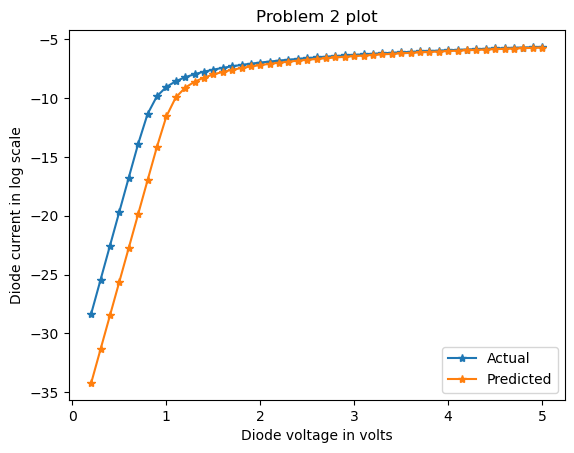

In [14]:
# Init the diode voltage for prediction
Vd_init = [1 for i in range(len(source_voltages))]

# Calculate the saturation current, diode voltage, diode current based upon the predicted values of phi
predicted_Is = Isat(n[0])
diode_voltage_pred = fsolve(error_func, Vd_init, args=(source_voltages, predicted_Is, n[0], R[0], TEMP2))
diode_current_pred = current(diode_voltage_pred, predicted_Is, n[0], TEMP2)

# Set axes params for the plot
plt.xlabel("Diode voltage in volts")
plt.ylabel("Diode current in log scale")
plt.title("Problem 2 plot")

# Plot the given values of Source voltage and diode current in DiodeIV.txt (Actual values)
plt.plot(source_voltages[1:], np.log(measured_current[1:]), label="Actual", marker='*')

# Plot the given values of diode current and diode voltage in DiodeIV.txt (Predicted values)
plt.plot(source_voltages[1:], np.log(diode_current_pred[1:]), label="Predicted", marker='*')
plt.legend()
plt.show()